In [1]:
import numpy as np
import pandas as pd
import zipfile
from sklearn.model_selection import train_test_split
from src.helpers import get_data, gridsearch_with_output, score_classifer, test_classifer
import src.cost_functions as cf

import numpy as np

from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
import xgboost as xgb
from xgboost.sklearn import XGBClassifier

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_validate, GridSearchCV, cross_val_score
from sklearn.metrics import recall_score, precision_score, f1_score, confusion_matrix
import time
import pickle
import matplotlib.pyplot as plt

from src.isolation_forest import train, predict, print_isf_confusion, isolation_forest_test_classifier

In [3]:
df_analysis = get_data()

In [4]:
y = df_analysis.pop('fraud')
X = df_analysis.copy()
X_train, X_test, y_train, y_test= train_test_split(X, y,
                                                   test_size=.2,
                                                   stratify=y,
                                                   shuffle=True,
                                                   random_state=1)

c_train = X_train['gts']
c_test = X_test['gts']

In [4]:
#Random Forest Grid Search Tuning
random_forest_grid = {'max_depth': [2, 4, None],
                      'max_features': ['sqrt', None],
                      'oob_score': [True, False],
                      'n_estimators': [20, 30],
                      'class_weight': ['balanced', None],
                      'random_state': [1]
                     }
rf_best_params, rf_best_model, rf_best_score = gridsearch_with_output(RandomForestClassifier(), 
                                                                      random_forest_grid, 
                                                                      'recall',
                                                                      X_train, y_train)

Fitting 5 folds for each of 48 candidates, totalling 240 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    3.8s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:   19.4s
[Parallel(n_jobs=-1)]: Done 240 out of 240 | elapsed:   34.0s finished



Result of gridsearch:
Parameter            | Optimal  | Gridsearch values
-------------------------------------------------------
max_depth            | 4        | [2, 4, None]
max_features         | sqrt     | ['sqrt', None]
oob_score            | True     | [True, False]
n_estimators         | 20       | [20, 30]
class_weight         | balanced | ['balanced', None]
random_state         | 1        | [1]


In [5]:
n=5
importances = rf_best_model.feature_importances_
indices = np.argsort(importances)[::-1]
features = list(X.columns[indices])
print("Feature ranking:")
for f in range(n):
    print("%d. %s (%f)" % (f + 1, features[f], importances[indices[f]]))
    
rf_best_score

Feature ranking:
1. sale_duration2 (0.190222)
2. org_facebook (0.103722)
3. user_age (0.099429)
4. user_type_1 (0.089524)
5. num_payouts (0.069148)


0.9068037602820211

/Users/isabella/opt/anaconda3/lib/python3.7/site-packages/pandas/core/computation/expressions.py:204: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


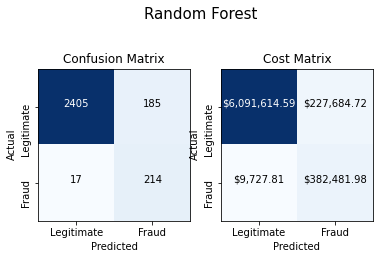

In [6]:
fig = cf.print_confusion(rf_best_model, "", X_train, y_train, X_test, y_test, c_test)
fig.suptitle("Random Forest", size=15)
fig.savefig('images/rf_matrix.png', bbox_inches = "tight")

In [7]:
#  Gradient Boost Grid Search
gb_grid = {'max_depth': [4, None],
           'max_features': ['sqrt', None],
           'min_samples_split': [2, 4, None],
           'min_samples_leaf': [1, None],
           'n_estimators': [40, 50],
           'learning_rate': [.5, .6],
           'random_state': [1]
                     }

gb_best_params, gb_best_model, gb_best_score = gridsearch_with_output(GradientBoostingClassifier(), 
                                                           gb_grid, 
                                                           'f1',
                                                           X_train, y_train)

Fitting 5 folds for each of 96 candidates, totalling 480 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:   35.8s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done 480 out of 480 | elapsed:  3.2min finished



Result of gridsearch:
Parameter            | Optimal  | Gridsearch values
-------------------------------------------------------
max_depth            | None     | [4, None]
max_features         | sqrt     | ['sqrt', None]
min_samples_split    | 4        | [2, 4, None]
min_samples_leaf     | 1        | [1, None]
n_estimators         | 50       | [40, 50]
learning_rate        | 0.6      | [0.5, 0.6]
random_state         | 1        | [1]


In [8]:
n=5
importances = gb_best_model.feature_importances_
indices = np.argsort(importances)[::-1]
features = list(X.columns[indices])
print("Feature ranking:")
for f in range(n):
    print("%d. %s (%f)" % (f + 1, features[f], importances[indices[f]]))
    
gb_best_score

Feature ranking:
1. payout_type_ (0.231896)
2. sale_duration2 (0.214292)
3. user_age (0.093404)
4. org_facebook (0.057802)
5. gts (0.048919)


0.8710500032832165

/Users/isabella/opt/anaconda3/lib/python3.7/site-packages/pandas/core/computation/expressions.py:204: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


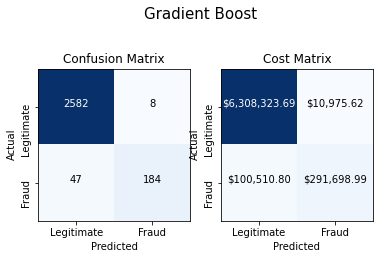

In [9]:
fig = cf.print_confusion(gb_best_model, "", X_train, y_train, X_test, y_test, c_test)
fig.suptitle("Gradient Boost", size=15)
fig.savefig('images/gb_matrix.png', bbox_inches = "tight")

In [10]:
xgb_grid = {'max_depth': [4, None],
            'min_child_weight': [.1, None],
           'learning_rate': [.4, .5],
           'random_state': [1]
                     }

xgb_best_params, xgb_best_model, xgb_best_score = gridsearch_with_output(XGBClassifier(), 
                                                           xgb_grid, 
                                                           'f1',
                                                           X_train, y_train)

Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:   54.1s finished
/Users/isabella/opt/anaconda3/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:48:38] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1607604592557/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.

Result of gridsearch:
Parameter            | Optimal  | Gridsearch values
-------------------------------------------------------
max_depth            | None     | [4, None]
min_child_weight     | 0.1      | [0.1, None]
learning_rate        | 0.5      | [0.4, 0.5]
random_state         | 1        | [1]


In [11]:
n=5
importances = xgb_best_model.feature_importances_
indices = np.argsort(importances)[::-1]
features = list(X.columns[indices])
print("Feature ranking:")
for f in range(n):
    print("%d. %s (%f)" % (f + 1, features[f], importances[indices[f]]))
    
xgb_best_score

Feature ranking:
1. payout_type_ (0.170804)
2. payout_type_CHECK (0.061795)
3. sale_duration2 (0.061306)
4. country_PR (0.058081)
5. num_payouts (0.052095)


0.8826067100755397

In [12]:
xgb_best_score

0.8826067100755397

[13:48:40] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1607604592557/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/isabella/opt/anaconda3/lib/python3.7/site-packages/pandas/core/computation/expressions.py:204: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


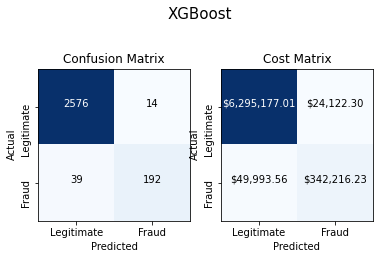

In [13]:
fig = cf.print_confusion(xgb_best_model, "", X_train, y_train, X_test, y_test, c_test)
fig.suptitle("XGBoost", size=15)
fig.savefig('images/xgb_matrix.png', bbox_inches = "tight")

In [14]:
# instantiate classifiers
rf = rf_best_model
xgb = xgb_best_model
gbc = gb_best_model

# instantiate voting classifier after other estimators have already been fit
estimators = [['rf',rf], ['xgb', xgb], ['gbc', gbc]]
voting = VotingClassifier(estimators, voting = 'soft', weights=[3,2,1])
voting.fit(X_train, y_train)


/Users/isabella/opt/anaconda3/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:48:43] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1607604592557/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


VotingClassifier(estimators=[['rf',
                              RandomForestClassifier(class_weight='balanced',
                                                     max_depth=4,
                                                     max_features='sqrt',
                                                     n_estimators=20,
                                                     oob_score=True,
                                                     random_state=1)],
                             ['xgb',
                              XGBClassifier(base_score=0.5, booster='gbtree',
                                            colsample_bylevel=1,
                                            colsample_bynode=1,
                                            colsample_bytree=1, gamma=0,
                                            gpu_id=-1, importance_type='gain',
                                            interaction_constraints='',
                                            learning_...
           

In [15]:
y_predict = voting.predict(X_test)

In [16]:
rf = rf_best_model
y_predict = rf.predict(X_test)
print("Random Forest")
print(f"precision: {precision_score(y_test, y_predict)}")
print(f"recall: {recall_score(y_test, y_predict)}")
print(f"f1: {f1_score(y_test, y_predict)}")
print(f"confusion matrix: \n {confusion_matrix(y_test, y_predict)} \n ")

xgb = xgb_best_model
y_predict = xgb.predict(X_test)
print("XGBoost")
print(f"precision: {precision_score(y_test, y_predict)}")
print(f"recall: {recall_score(y_test, y_predict)}")
print(f"f1: {f1_score(y_test, y_predict)}")
print(f"confusion matrix: \n {confusion_matrix(y_test, y_predict)} \n ")

gb = gb_best_model
y_predict = gb.predict(X_test)
print("Gradient Boost")
print(f"precision: {precision_score(y_test, y_predict)}")
print(f"recall: {recall_score(y_test, y_predict)}")
print(f"f1: {f1_score(y_test, y_predict)}")
print(f"confusion matrix: \n {confusion_matrix(y_test, y_predict)} \n ")


y_predict = voting.predict(X_test)
print("Voting")
print(f"precision: {precision_score(y_test, y_predict)}")
print(f"recall: {recall_score(y_test, y_predict)}")
print(f"f1: {f1_score(y_test, y_predict)}")
print(f"confusion matrix: \n {confusion_matrix(y_test, y_predict)} \n ")


Random Forest
precision: 0.5363408521303258
recall: 0.9264069264069265
f1: 0.6793650793650794
confusion matrix: 
 [[2405  185]
 [  17  214]] 
 
XGBoost
precision: 0.9320388349514563
recall: 0.8311688311688312
f1: 0.8787185354691076
confusion matrix: 
 [[2576   14]
 [  39  192]] 
 
Gradient Boost
precision: 0.9583333333333334
recall: 0.7965367965367965
f1: 0.8699763593380614
confusion matrix: 
 [[2582    8]
 [  47  184]] 
 
Voting
precision: 0.933649289099526
recall: 0.8528138528138528
f1: 0.8914027149321267
confusion matrix: 
 [[2576   14]
 [  34  197]] 
 


/Users/isabella/opt/anaconda3/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:48:59] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1607604592557/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/isabella/opt/anaconda3/lib/python3.7/site-packages/pandas/core/computation/expressions.py:204: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


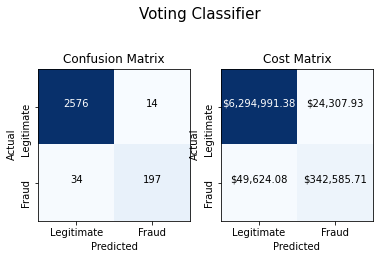

In [17]:
fig = cf.print_confusion(voting, "", X_train, y_train, X_test, y_test, c_test)
fig.suptitle("Voting Classifier", size=15)
fig.savefig('images/voting_matrix.png', bbox_inches = "tight")

In [34]:
filename = 'voting_model.pickle'
pickle.dump(voting, open(filename, 'wb'))

In [5]:
isolation_forest_test_classifier(X_train, X_test,
                                 y_train, y_test,
                                 c_train, c_test,
                                 df_analysis)

Isolation Forest
Recall: 0.8798298475717831
Precision: 0.8545779151878995
f1_score: 0.866508106084272


(0.8545779151878995, 0.8798298475717831, 0.866508106084272)

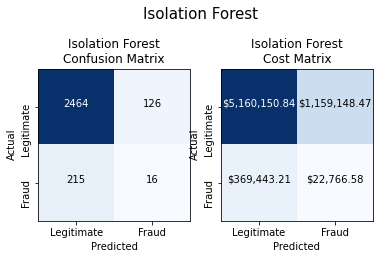

In [7]:
fig = print_isf_confusion(X_train, X_test, y_train, y_test, c_train, c_test, df_analysis)

fig.suptitle("Isolation Forest", size=15)
fig.savefig('images/if_matrix.png', bbox_inches = "tight")